# Возрастная классификация по голосу

### Необходимые импорты и установка системных переменных

In [1]:
import os
os.environ['HF_HOME'] = '/home/jovyan/work/ramdisk/shlyahin/HF_cache/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import timit_utils as tu

import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

from scipy.io.wavfile import write

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier

import pickle

#import IPython
_TIMIT_PATH = './data/lisa/data/timit/raw/TIMIT'
DATA_PATH = './data/timit_age'

In [3]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')
device

device(type='cuda', index=0)

In [4]:
# Зафиксируем рандомы
import random
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Данные

Для экспериментов и обучения используется датасет TIMIT, который содержит в общей сложности 6300 предложений, по 10 предложений, произнесенных каждым из 630 носителей из 8 основных диалектных регионов Соединенных Штатов.

In [5]:
data_path=_TIMIT_PATH
doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
corpus = tu.Corpus(data_path)

Извлечем нужные данные (пол и возраст) из разметки

In [6]:
with open(doc_file_path) as f:
    id_age_dict = dict(
        [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
        for tmp in f.readlines()[39:]])
    id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

Возраст (три возрастных интервала)

In [7]:
def clasterize_by_age(age):
    if age <= 25:
        cl_age = 0
    if 25 < age <= 40:
        cl_age = 1
    if 40 < age:
        cl_age = 2
    return int(cl_age)

Загрузим две модели - SpeakerNet и TitaNet - для получения эмбеддингов спикеров.

In [9]:
import nemo.collections.asr as nemo_asr
speakernet_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name="speakerverification_speakernet")
titanet_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name='titanet_large')

[NeMo I 2023-12-06 10:49:23 cloud:58] Found existing object /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/speakerverification_speakernet/a8330fa516557b963a89ccbf0fcbe2f2/speakerverification_speakernet.nemo.
[NeMo I 2023-12-06 10:49:23 cloud:64] Re-using file from: /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/speakerverification_speakernet/a8330fa516557b963a89ccbf0fcbe2f2/speakerverification_speakernet.nemo
[NeMo I 2023-12-06 10:49:23 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-12-06 10:49:23 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /ws/manifests/raid/combined/train_manifest.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 8
    augmentor:
      noise:
        manifest_path: /ws/manifests/raid/musan/musan_music_noise_manifest_dur8.json
        prob: 0.2
        min_snr_db: 5
        max_snr_db: 15
    num_workers: 4
    
[NeMo W 2023-12-06 10:49:23 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /ws/manifests/raid/voxceleb/small_manifest.json
    sample_rate: 16000
    labels: null
    batch_size:

[NeMo I 2023-12-06 10:49:23 features:289] PADDING: 16
[NeMo I 2023-12-06 10:49:30 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/speakerverification_speakernet/a8330fa516557b963a89ccbf0fcbe2f2/speakerverification_speakernet.nemo.
[NeMo I 2023-12-06 10:49:30 cloud:58] Found existing object /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.
[NeMo I 2023-12-06 10:49:30 cloud:64] Re-using file from: /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo
[NeMo I 2023-12-06 10:49:30 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-12-06 10:49:30 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-12-06 10:49:30 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method 

[NeMo I 2023-12-06 10:49:30 features:289] PADDING: 16
[NeMo I 2023-12-06 10:49:32 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/jovyan/.cache/torch/NeMo/NeMo_1.21.0/titanet-l/11ba0924fdf87c049e339adbf6899d48/titanet-l.nemo.


In [11]:
def create_wav_file(raw_audio, output_path, sampling_rate=16000):
    """
    Создание файла WAV из данных raw_audio.

    :param raw_audio: Данные raw_audio
    :param sampling_rate: Частота дискретизации аудио
    :param output_path: Путь для сохранения файла WAV
    """
    # Нормализация данных в диапазон от -1 до 1
    normalized_audio = raw_audio / np.max(np.abs(raw_audio))

    # Преобразование в 16-битный формат
    audio_data = (normalized_audio * 32767).astype(np.int16)

    # Сохранение в файл WAV
    write(output_path, sampling_rate, audio_data)

Сформируем датасет

In [ ]:
data = []
k = 0
for mode in ['train', 'valid', 'test']:
    
    if mode == 'train':
        people = [corpus.train.person_by_index(i) for i in range(350)]
    if mode == 'valid':
        people = [corpus.train.person_by_index(i) for i in range(350, 400)]
    if mode == 'test':
        people = [corpus.test.person_by_index(i) for i in range(150)]

    for person in tqdm_notebook(people):
        try:
            age = id_age_dict[person.name]
            target = clasterize_by_age(age)
            for i in range(len(person.sentences)):
                raw_audio = person.sentence_by_index(i).raw_audio
                wav_path = os.path.join(DATA_PATH, f'audio/{k:06}.wav')
                create_wav_file(raw_audio, wav_path)
                sn_emb = ';'.join(map(str, speakernet_model.get_embedding(wav_path).squeeze().detach().cpu().tolist()))
                tn_emb = ';'.join(map(str, titanet_model.get_embedding(wav_path).squeeze().detach().cpu().tolist()))
                data.append({'mode': mode,
                             'path': f'audio/{k:06}.wav',
                             'target': target,
                             'sex': 0,
                             'age': age,
                             'sn_emb': sn_emb,
                             'tn_emb': tn_emb})
                k += 1
                
        except:
              print(person.name, target)

[NeMo W 2023-12-06 10:50:01 nemo_logging:349] /tmp/ipykernel_2264080/3777693499.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
    Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
      for person in tqdm_notebook(people):
    


  0%|          | 0/350 [00:00<?, ?it/s]

In [46]:
pd.DataFrame(data).to_csv(os.path.join(DATA_PATH, 't_age.csv'), index=False)

In [8]:
df = pd.read_csv(os.path.join(DATA_PATH, 't_age.csv'))

In [9]:
len(df)

5500

In [12]:
df_train = df[df['mode'] == 'train']
df_val = df[df['mode'] == 'valid']
df_test = df[df['mode'] == 'test']

In [13]:
X_train_sn = [[float(y) for y in x.split(';')] for x in df_train['sn_emb'].tolist()]
X_train_tn = [[float(y) for y in x.split(';')] for x in df_train['tn_emb'].tolist()]
y_train = [x for x in df_train['target'].tolist()]
X_val_sn = [[float(y) for y in x.split(';')] for x in df_val['sn_emb'].tolist()]
X_val_tn = [[float(y) for y in x.split(';')] for x in df_val['tn_emb'].tolist()]
y_val = [x for x in df_val['target'].tolist()]
X_test_sn = [[float(y) for y in x.split(';')] for x in df_test['sn_emb'].tolist()]
X_test_tn = [[float(y) for y in x.split(';')] for x in df_test['tn_emb'].tolist()]
y_test = [x for x in df_test['target'].tolist()]

Распределение классов

<Axes: >

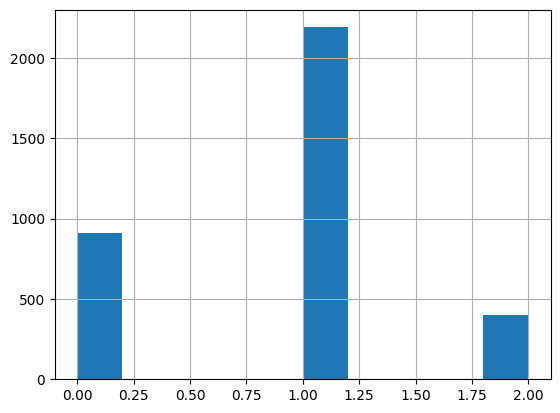

In [12]:
df[df['mode'] == 'train']['target'].hist()

<Axes: >

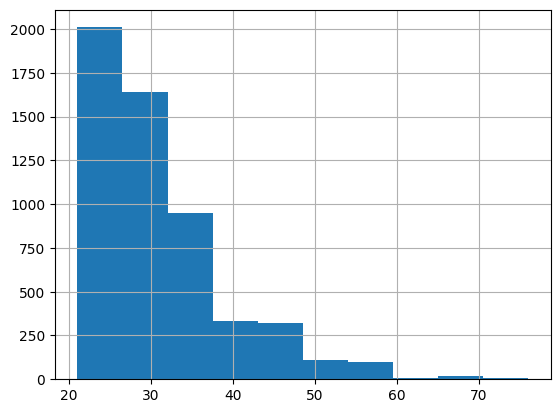

In [50]:
df['age'].hist()

Применение PCA и построение диаграммы рассеивания

In [10]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=2)
tn_pca = pca.fit_transform(X_train_tn)

In [18]:
clr_dict = {0: 'r', 1: 'g', 2: 'b'}
clrs = [clr_dict[y] for y in y_train]

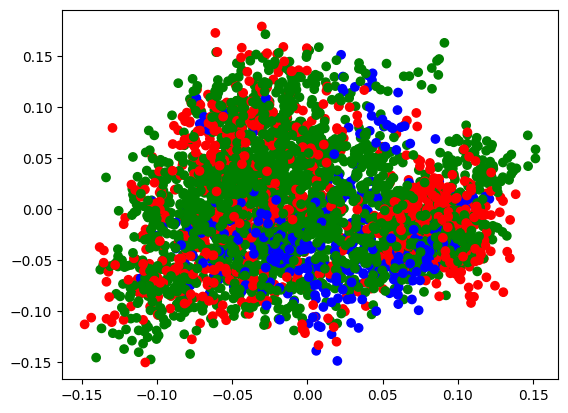

In [19]:
plt.scatter(tn_pca[:, 0], tn_pca[:, 1], c=clrs)
plt.show()

In [20]:
pca = PCA(n_components=2)
sn_pca = pca.fit_transform(X_train_sn)

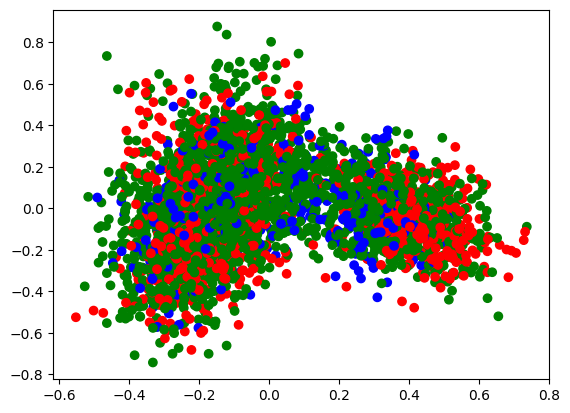

In [21]:
plt.scatter(sn_pca[:, 0], sn_pca[:, 1], c=clrs)
plt.show()

### Baseline - константный классификатор: y = 1

In [84]:
from sklearn.metrics import accuracy_score

In [87]:
accuracy_score(y_val, [1] * len(y_val))

0.58

In [26]:
accuracy_score(y_test, [1] * len(y_test))

0.62

### kNN на эмбеддингах

Подбор гиперпараметров

In [82]:
best_acc = 0.0
for metric in ['minkowski', 'cosine']:
    for n_neighbors in range(1, 50):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train_tn, y_train)
        score = knn.score(X_val_tn, y_val)
        if score > best_acc + 0.01:
            best_acc = score
            best_hparams = {'metric': metric,
                            'n_neighbors': n_neighbors,
                            'accuracy': best_acc}
print(best_hparams)            

{'metric': 'minkowski', 'n_neighbors': 37, 'accuracy': 0.692}


In [83]:
best_acc = 0.0
for metric in ['minkowski', 'cosine']:
    for n_neighbors in range(1, 50):
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train_sn, y_train)
        score = knn.score(X_val_sn, y_val)
        if score > best_acc + 0.01:
            best_acc = score
            best_hparams = {'metric': metric,
                            'n_neighbors': n_neighbors,
                            'accuracy': best_acc}
print(best_hparams)     

{'metric': 'minkowski', 'n_neighbors': 33, 'accuracy': 0.62}


Сохранение лучшего классификатора

In [15]:
knn = KNeighborsClassifier(n_neighbors=37, metric='minkowski')
knn.fit(X_train_tn, y_train)
pickle.dump(knn, open('weights/knn_age_tn.pkl', 'wb'))

Измерим тестовое качество выбранного классификатора

In [14]:
age_model = pickle.load(open('./weights/knn_age_tn.pkl', 'rb'))
score = age_model.score(X_test_tn, y_test)
print(score)

0.6026666666666667


### Попробуем использовать FCN

In [16]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
import torchvision.models as models
import torch.nn as nn

In [17]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        features = torch.tensor(self.X[idx])
        label = torch.tensor(self.y[idx])
        encoding = {"features": features,
                    "labels": label}
        return encoding

In [57]:
train_dataset = MyDataset(X_train_tn, y_train)
eval_dataset = MyDataset(X_val_tn, y_val)
test_dataset = MyDataset(X_test_tn, y_test)

In [58]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of validation examples:", len(test_dataset))

Number of training examples: 3500
Number of validation examples: 500
Number of validation examples: 1500


In [59]:
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [60]:
class FCNModel(nn.Module):
    def __init__(self, num_classes, dim, hid_dim, dropoutrate):
        super(FCNModel, self).__init__()
                
        self.model = nn.Sequential(nn.Linear(dim, hid_dim),
            nn.ReLU(),                                   
            nn.Dropout(dropoutrate),
            nn.Linear(hid_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [62]:
model = FCNModel(3, 192, 32, 0.5).to(device)
optimizer = AdamW(model.parameters(), lr=0.0001) #0.0001) #1e-3)
criterion = nn.CrossEntropyLoss()
exp_name = 'voice_to_age_tn_32_do05'
restart_epoch = 0
n_epochs = 1500
train_losses = []
val_losses = []
val_accs = []
best_metric = 0.


if restart_epoch > 0:
    model.load_state_dict(torch.load(f'weights/{exp_name}.pth'))
    metrics_df = pd.read_csv(f'./logs/{exp_name}.csv')
    train_losses = list(metrics_df['train_loss'].values)
    val_losses = list(metrics_df['val_loss'].values)
    val_accs = list(metrics_df['val_acc'].values)
    best_metric = max(val_accs)

for epoch in tqdm(range(restart_epoch, n_epochs)):  # loop over the dataset multiple times
    # train
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        inputs, labels = batch['features'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)  
    #print(f"Train loss after epoch {epoch}:", train_loss)
    
    # evaluate
    model.eval()
    val_acc = 0.0
    val_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            inputs, labels = batch['features'].to(device), batch['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accu = correct / total
    val_loss /= len(eval_dataloader)
    val_losses.append(val_loss)
    val_accs.append(accu)
    #print(f"Val loss after epoch {epoch}:", val_loss, f"Val accuracy after epoch {epoch}:", accu)
    if accu > best_metric:
        best_metric = accu
        torch.save(model.state_dict(), f'./weights/{exp_name}.pth')
    metrics_df = pd.DataFrame({'epoch': list(range(epoch + 1)),
                              'train_loss': train_losses,
                              'val_loss': val_losses,
                              'val_acc' : val_accs})
    metrics_df.to_csv(f'./logs/{exp_name}.csv', index=False)
print(best_metric)

100%|██████████| 1500/1500 [09:11<00:00,  2.72it/s]

0.694


In [64]:
model = FCNModel(3, 192, 32, 0.5).to(device)
exp_name = 'voice_to_age_tn_32_do05'
model.load_state_dict(torch.load(f'weights/{exp_name}.pth'))
    
# evaluate
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch['features'].to(device), batch['labels'].to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
accu = correct / total
print(accu)

0.6526666666666666


Можно попробовать архитектуру побольше

In [65]:
class FCN2(nn.Module):
    def __init__(self, num_classes=3):
        super(FCN2, self).__init__()

        self.fc1 = nn.Linear(192, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x):

        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.sigmoid(self.fc2(x)))

        logits = self.fc(x)  
        return logits    

In [67]:
model = FCN2().to(device)
optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5, lr=1e-4
)
criterion = nn.CrossEntropyLoss()
exp_name = 'voice_to_age_tn_FCN2'
N_EPOCHS = 1500
best_acc = 0.0

for i in tqdm(range(N_EPOCHS)):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input, target = batch['features'].to(device), batch['labels'].to(device)
        #out = model(input.float().unsqueeze(1))
        out = model(input.float())
        loss = criterion(out.cpu(), target.long().cpu())
        loss.backward()
        optimizer.step()
    model.eval()
    valid_losses = []
    valid_accs = []
    
    with torch.no_grad():
        for batch in eval_dataloader:
            input, target = batch['features'].to(device), batch['labels'].to(device)
            #out = model(input.float().unsqueeze(1))
            out = model(input.float())
            valid_loss = criterion(out.cpu(), target.long().cpu())
            out, target = torch.argmax(out, dim=1).cpu().detach().numpy(), target.long().cpu().detach().numpy()
            # print(out, target)
            valid_losses.append(valid_loss.item())
            valid_accs.append(accuracy_score(out, target))
    acc = np.array(valid_accs).mean()        
    #print(f'accuracy_score:{acc}')
    #print("valid {}".format(np.array(valid_losses).mean()))
    #print("_________")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), f'./weights/{exp_name}.pth')

100%|██████████| 1500/1500 [09:58<00:00,  2.51it/s]


In [68]:
best_acc

0.685614224137931

In [69]:
model.load_state_dict(torch.load(f'weights/{exp_name}.pth'))
# evaluate
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch['features'].to(device), batch['labels'].to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
accu = correct / total
print(accu)

0.666


### Попробуем работать непосредственно с мел-спектрограммами

### Формирование датасета

В качестве признаков на модели подаются MEL-спектрограммы

In [76]:
class timit_dataset:
    
    def __init__(self, data_path=_TIMIT_PATH,mode='train', age_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)

        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        self.dataset = self.create_dataset(mode, age_mode=age_mode)
    
    def __len__(self):
        return len(self.dataset[1])

    def __getitem__(self, idx):
        return self.dataset[0][idx], self.dataset[1][idx] 

    def return_age(self, id):
        return self.id_age_dict[id]
    
    def create_dataset(self, mode, age_mode=True):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm_notebook(people):
            #try:
                target = self.clasterize_by_age(self.return_age(person.name))
                for i in range(len(person.sentences)):
                    spectrograms_and_targets.append(
                        self.preprocess_sample(person.sentence_by_index(i).raw_audio,
                                               target, age_mode=True)
                    )
            #except:
            #     print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled
   

    @staticmethod
    def clasterize_by_age(age):
        if age <= 25:
            cl_age = 0
        if 25 < age <= 40:
            cl_age = 1
        if 40 < age:
            cl_age = 2
        
        return int(cl_age)

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(y=amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(y=amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)

In [77]:
train = timit_dataset(mode='train')
valid = timit_dataset(mode='valid')
test = timit_dataset(mode='test')

/tmp/ipykernel_1170/1877803685.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for person in tqdm_notebook(people):


  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [78]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

### Эксперименты

Простая сверточная сеть

In [79]:
class Model0(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5), num_classes=3, n_mels=128, hid_dim=128):
        super(Model0, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, hid_dim, [window_size, n_mels], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(hid_dim * len(window_sizes), num_classes)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        #probs = torch.sigmoid(logits).view(-1)
        return logits

In [86]:
model = Model0().to(device)
optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5, lr=1e-4
)
criterion = nn.CrossEntropyLoss()

In [87]:
N_EPOCHS = 200
best_acc = 0.0
exp_name = 'model0'

for i in tqdm(range(N_EPOCHS)):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input, target = batch[0].to(device), batch[1].to(device)
        #out = model(input.float().unsqueeze(1))
        out = model(input.float())
        loss = criterion(out, target.long())
        loss.backward()
        optimizer.step()
    model.eval()
    valid_losses = []
    valid_accs = []
    
    with torch.no_grad():
        for batch in valid_dataloader:
            input, target = input, target = batch[0].to(device), batch[1].to(device)
            #out = model(input.float().unsqueeze(1))
            out = model(input.float())
            valid_loss = criterion(out, target.long())
            out, target = torch.argmax(out, dim=1).cpu().detach().numpy(), target.long().cpu().detach().numpy()
            # print(out, target)
            valid_losses.append(valid_loss.item())
            valid_accs.append(accuracy_score(out, target))
    acc = np.array(valid_accs).mean()
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), f'./weights/{exp_name}.pth')
print(best_acc)        

100%|██████████| 200/200 [21:25<00:00,  6.43s/it]

0.5497295673076923


In [88]:
model = Model0().to(device)
model.load_state_dict(torch.load(f'./weights/{exp_name}.pth'))
model.eval()
test_loss = 0
test_acc = 0
i = 0
for batch in test_dataloader:
    with torch.no_grad():
        input, target = batch[0].to(device), batch[1].to(device)
        #out = model(input.float().unsqueeze(1))
        out = model(input.float())             
        test_loss += criterion(out, target.long())
        out, target = torch.argmax(out, dim=1).cpu().detach().numpy(), target.long().cpu().detach().numpy()
        test_acc += accuracy_score(out, target)
        i += 1
print ('Test loss: ', test_loss / i,' Test accuracy: ', test_acc / i )

Test loss:  tensor(1.4685, device='cuda:0')  Test accuracy:  0.5829613095238095


### Усложним модель

In [89]:
class Model1(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5), num_classes=3, n_mels=128):
        super(Model1, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, n_mels], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])
        self.fc0 = nn.Linear(128 * len(window_sizes), 128)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(128, num_classes)



    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            #x2 = self.dropout(x2)
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        x = self.dropout(self.relu(self.fc0(x)))

        logits = self.fc(x)  # [B, class]
        #probs = torch.sigmoid(logits).view(-1)
        return logits

In [90]:
BATCH_SIZE = 64
model = Model1().to(device)
optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5, lr=1e-4
)
criterion = nn.CrossEntropyLoss()

In [91]:
N_EPOCHS = 200
best_acc = 0.0
exp_name = 'model1'

for i in tqdm(range(N_EPOCHS)):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input, target = batch[0].to(device), batch[1].to(device)
        #out = model(input.float().unsqueeze(1))
        out = model(input.float())
        loss = criterion(out, target.long())
        loss.backward()
        optimizer.step()
    model.eval()
    valid_losses = []
    valid_accs = []
    
    with torch.no_grad():
        for batch in valid_dataloader:
            input, target = input, target = batch[0].to(device), batch[1].to(device)
            #out = model(input.float().unsqueeze(1))
            out = model(input.float())
            valid_loss = criterion(out, target.long())
            out, target = torch.argmax(out, dim=1).cpu().detach().numpy(), target.long().cpu().detach().numpy()
            # print(out, target)
            valid_losses.append(valid_loss.item())
            valid_accs.append(accuracy_score(out, target))
    acc = np.array(valid_accs).mean()
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), f'./weights/{exp_name}.pth')
print(best_acc)  

100%|██████████| 200/200 [21:34<00:00,  6.47s/it]

0.5988581730769231


In [93]:
model = Model1().to(device)
model.load_state_dict(torch.load(f'./weights/{exp_name}.pth'))
model.eval()
test_loss = 0
test_acc = 0
i = 0
for batch in test_dataloader:
    with torch.no_grad():
        input, target = batch[0].to(device), batch[1].to(device)
        #out = model(input.float().unsqueeze(1))
        out = model(input.float())             
        test_loss += criterion(out, target.long())
        out, target = torch.argmax(out, dim=1).cpu().detach().numpy(), target.long().cpu().detach().numpy()
        test_acc += accuracy_score(out, target)
        i += 1
print ('Test loss: ', test_loss / i,' Test accuracy: ', test_acc / i )

Test loss:  tensor(1.1180, device='cuda:0')  Test accuracy:  0.607235863095238


Попробуем предсказывать сначала сам возраст - с помощью RNN, а потом - возрастной интервал.

In [94]:
class Model6(nn.Module):
    def __init__(self, hid_dim=128):
        super(Model6, self).__init__()

        self.rnn = nn.LSTM(input_size=128, hidden_size=hid_dim, num_layers=2,
                          batch_first=True, dropout=0.5, bidirectional=True)

        self.fc = nn.Linear(hid_dim * 2, 1)

    def forward(self, x):
        x, _ = self.rnn(x)
        # FC
        x = x[:, -1,:].view(x.size(0), -1)
        logits = self.fc(x)  # [B, class]
        #probs = torch.sigmoid(logits).view(-1)
        return logits

In [97]:
class timit_dataset2:
    def __init__(self, data_path=_TIMIT_PATH,mode='train', age_mode=True, n_mels=128):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        self.n_mels=n_mels
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        self.dataset = self.create_dataset(mode, age_mode=age_mode)
    
    def __len__(self):
        return len(self.dataset[1])

    def __getitem__(self, idx):
        return self.dataset[0][idx], self.dataset[1][idx] 

    def return_age(self, id):
        return self.id_age_dict[id]
    
    def return_sex(self, id):
        return self.id_sex_dict[id]

    def create_dataset(self, mode, age_mode=True):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm_notebook(people):
            #try:
                target = self.return_age(person.name) / 80
                for i in range(len(person.sentences)):
                    spectrograms_and_targets.append(
                        self.preprocess_sample(person.sentence_by_index(i).raw_audio,
                                               target, age_mode=True)
                    )
            #except:
            #      print(person.name, target)

        X, y = map(np.stack, zip(*spectrograms_and_targets))
        X = X.transpose([0, 2, 1])  # to [batch, time, channels]
        return X, y

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled
   

    @staticmethod
    def clasterize_by_age(age):
        if age <= 25:
            cl_age = 0
        if 25 < age <= 40:
            cl_age = 1
        if 40 < age:
            cl_age = 2
        
        return int(cl_age)

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(y=amplitudes, sr=sr, n_mels=self.n_mels, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        
        return self.spec_to_image(np.float32(spectrogram)), target

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(y=amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])

        return torch.tensor(spectrogram, dtype=torch.float).to(device, non_blocking=True)

In [98]:
train = timit_dataset2(mode='train')
valid = timit_dataset2(mode='valid')
test = timit_dataset2(mode='test')

/tmp/ipykernel_1170/648469655.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for person in tqdm_notebook(people):


  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

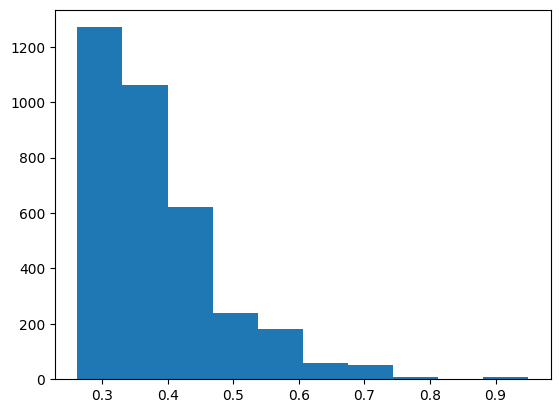

In [99]:
plt.hist(train[:][1])
plt.show()

In [100]:
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
def age_to_class(age, age1=25, age2=40):
    if age <= age1:
        cl_age = 0
    if age1 < age <= age2:
        cl_age = 1
    if age2 < age:
        cl_age = 2
    return int(cl_age)

In [122]:
BATCH_SIZE = 64
model = Model6().to(device)
optimizer = Adam(
    [p for p in model.parameters() if p.requires_grad], betas=(0.9, 0.999), eps=1e-5, lr=1e-2
)
criterion = nn.MSELoss()

In [123]:
N_EPOCHS = 50 #200
best_mae = float('inf')
exp_name = 'model6'

for i in tqdm(range(N_EPOCHS)):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        input, target = batch[0].to(device), batch[1].float().to(device)
        out = model(input.float()).float().squeeze(1)
        loss = criterion(out, target.float())
        loss.backward()
        optimizer.step()
    model.eval()
    valid_losses = []
    valid_maes = []
    
    with torch.no_grad():
        for batch in valid_dataloader:
            input, target = input, target = batch[0].to(device), batch[1].float().to(device)
            out = model(input.float()).float().squeeze(1)
            valid_loss = criterion(out, target.float())
            out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
            valid_losses.append(valid_loss.item())
            valid_maes.append(mean_absolute_error(out, target))
    mae = np.array(valid_maes).mean()
    #print(mae)
    if mae < best_mae:
        best_mae = mae
        torch.save(model.state_dict(), f'./weights/{exp_name}.pth')
print(best_mae)  

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]

0.07064659


In [124]:
model = Model6().to(device)
model.load_state_dict(torch.load(f'./weights/{exp_name}.pth'))
model.eval()
test_loss = 0
test_MAE = 0
test_acc = 0
i = 0
for batch in test_dataloader:
    with torch.no_grad():
        input, target = batch[0].to(device), batch[1].float().to(device)
        #out = model(input.float().unsqueeze(1))
        out = model(input.float()).float().squeeze(1)           
        test_loss += criterion(out, target)
        out, target = out.cpu().detach().numpy(), target.cpu().detach().numpy()
        test_MAE += mean_absolute_error(out, target)
        out1 = list(map(age_to_class, out * 80))
        target1 = list(map(age_to_class, target * 80))
        test_acc += accuracy_score(out1, target1)
        i += 1
print ('Test loss: ', test_loss / i,' Test MAE: ', test_MAE / i * 80, ' Test acc: ', test_acc / i)

Test loss:  tensor(0.0131, device='cuda:0')  Test MAE:  5.8090588326255475  Test acc:  0.618954613095238


Важно отметить, что ручная человеческая оценка возраста на 50 примерах из valid. Human level метрики: MAE 8.16 , accuracy  0.42.